(supervised:linear-regression:example1)=
# Worked Example: House Prices I

To test techniques for supervised learning discussed so far we train a model for predicting house prices in Germany. Inputs are properties of a house and of the plot of land it has been built on. Output is the selling price.

Training data exists in form of advertisements on specialized websites for finding a buyer for a house. In principle we could scrape data from such a website, but usually its not allowed by the website operator and we would have to write lots of code. [Erdogan Seref](https://www.kaggle.com/scriptsultan) (unreachable in 2023) already did this job at [www.immobilienscout24.de](https://www.immobilienscout24.de) and published the data set at [www.kaggle.com](https://www.kaggle.com/scriptsultan/german-house-prices) (unreachable in 2023) under a [Attribution-NonCommercial-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-nc-sa/4.0).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import sklearn.pipeline as pipeline

data_path = 'german_housing.csv'

## The Data Set

At first we load the data set and try to get an overview of features and data quality.

In [2]:
data = pd.read_csv(data_path)

If a data frame has many columns Pandas by default does not show all columns. But we want to see all. Thus, we have to adjust the number of columns shown by [setting corresponding option](https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#frequently-used-options) to `None` (that is, unlimited).

In [3]:
pd.set_option('display.max_columns', None)
data.head(10)

Unnamed: 0      Price               Type  Living_space     Lot  \
0           0   498000.0  Multiple dwelling        106.00   229.0   
1           1   495000.0  Mid-terrace house        140.93   517.0   
2           2   749000.0          Farmhouse        162.89    82.0   
3           3   259000.0          Farmhouse        140.00   814.0   
4           4   469000.0  Multiple dwelling        115.00   244.0   
5           5  1400000.0  Mid-terrace house        310.00   860.0   
6           6  3500000.0             Duplex        502.00  5300.0   
7           7   630000.0             Duplex        263.00   406.0   
8           8   364000.0             Duplex        227.00   973.0   
9           9  1900000.0             Duplex        787.00   933.0   

   Usable_area     Free_of_Relation  Rooms  Bedrooms  Bathrooms  Floors  \
0          NaN          01.10.2020     5.5       3.0        1.0     2.0   
1        20.00          01.01.2021     6.0       3.0        2.0     NaN   
2        37.62          01.07.2020     5.0       3.0        2.0     4.0   
3          NaN   nach Vereinbarung     4.0       NaN        2.0     2.0   
4          NaN              sofort     4.5       2.0        1.0     NaN   
5       100.00              sofort     8.0       NaN        NaN     3.0   
6       163.16      nach Absprache    13.0       NaN        4.0     NaN   
7       118.00          01.04.2020    10.0       NaN        NaN     3.0   
8        83.00      nach Absprache    10.0       4.0        4.0     2.0   
9          NaN                  NaN   30.0       NaN        NaN     3.0   

   Year_built Furnishing_quality  Year_renovated    Condition  \
0      2005.0             normal             NaN   modernized   
1      1994.0              basic             NaN   modernized   
2      2013.0                NaN             NaN  dilapidated   
3      1900.0              basic          2000.0  fixer-upper   
4      1968.0            refined          2019.0  refurbished   
5      1969.0              basic             NaN   maintained   
6      2004.0              basic             NaN  dilapidated   
7      1989.0              basic             NaN   modernized   
8      1809.0             normal          2015.0   modernized   
9      1920.0              basic             NaN   modernized   

           Heating            Energy_source   Energy_certificate  \
0  central heating                     Gas             available   
1    stove heating                      NaN  not required by law   
2    stove heating   Fernwärme, Bioenergie             available   
3  central heating                   Strom             available   
4  central heating                      Öl             available   
5              NaN                      Öl             available   
6    stove heating   Erdwärme, Holzpellets             available   
7    stove heating                     Gas             available   
8  central heating                   Strom             available   
9    stove heating    Gas, Fernwärme-Dampf             available   

   Energy_certificate_type  Energy_consumption Energy_efficiency_class  \
0       demand certificate                 NaN                      D    
1                      NaN                 NaN                     NaN   
2       demand certificate                 NaN                      B    
3       demand certificate                 NaN                      G    
4       demand certificate                 NaN                      F    
5  consumption certificate                 NaN                     NaN   
6  consumption certificate                35.9                      A    
7       demand certificate                 NaN                      E    
8  consumption certificate               183.1                      F    
9       demand certificate                 NaN                      D    

               State                  City                    Place  Garages  \
0  Baden-Württemberg         Bodenseekreis              B

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10552 entries, 0 to 10551
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               10552 non-null  int64  
 1   Price                    10552 non-null  float64
 2   Type                     10150 non-null  object 
 3   Living_space             10552 non-null  float64
 4   Lot                      10552 non-null  float64
 5   Usable_area              5568 non-null   float64
 6   Free_of_Relation         6983 non-null   object 
 7   Rooms                    10552 non-null  float64
 8   Bedrooms                 6878 non-null   float64
 9   Bathrooms                8751 non-null   float64
 10  Floors                   7888 non-null   float64
 11  Year_built               9858 non-null   float64
 12  Furnishing_quality       7826 non-null   object 
 13  Year_renovated           5349 non-null   float64
 14  Condition             

We should drop irrelevant columns and adjust data types.

* `Unnamed: 0`: Seems to be an integer index. We don't need it, so drop it.
* `Price`: This is our target variable.
* `Type`: An important column, because house prices are likely to depend on the type of house. We should convert this to categorical type.
* `Living_space` and `Lot`: Important features, keep them.
* `Usable_area`: Likely to have influence on the selling price, but available only for half the samples. If we want to use this for regression, we would have to drop half the training samples. Alternatively we could impute values, but it's very hard to guess usable area from other features. We should drop the column.
* `Free_of_Relation`: Not related to the selling price. Drop it.
* `Rooms`, `Bedrooms`, `Bathrooms`: Should have influence on prices, but not available for all samples. For the moment we keep all three columns. Later we should have a look on correlations between the three columns and possibly only keep the first one, which is available for all samples.
* `Floors`: Important feature, keep it.
* `Year_built`: Important feature, keep it.
* `Furnishing_quality`: Important, convert to categorical and keep.
* `Year_renovated`: Important, but half the data is missing. There is good chance that missing values indicate that there the house has not been renovated until today. Thus, a reasonable fill value is the year of construction.
* `Condition`: Important, convert to categorical and keep.
* `Heating` and `Energy_source`: Could be important, convert to categorical and keep.
* `Energy_certificate`, `Energy_certificate_type`, `Energy_consumption`: The first contains more or less only the value `'available'` (since energy certificates are required by law). The second is irrelevant and the third is missing for most samples. Drop them all.
* `Energy_efficiency_class`: Likely to have influence on the selling price, although classification procedure is very unreliable in practice. Keep and convert to categorical.
* `State`, `City`, `Place`: Geolocation surely influences selling prices. But it's hard to use location data for regression. For the moment we keep these columns.
* `Garages`: Could be important, keep.
* `Garagetype`: If we keep `Garages` then we also have to keep this column. Convert to categorical and rename to `Garage_type` to fit naming convention used for the other columns.

In [5]:
data = data.drop(columns=['Unnamed: 0', 'Usable_area', 'Free_of_Relation',
                          'Energy_certificate', 'Energy_certificate_type', 'Energy_consumption'])

data['Type'] = data['Type'].astype('category')
data['Furnishing_quality'] = data['Furnishing_quality'].astype('category')
data['Condition'] = data['Condition'].astype('category')
data['Heating'] = data['Heating'].astype('category')
data['Energy_source'] = data['Energy_source'].astype('category')
data['Energy_efficiency_class'] = data['Energy_efficiency_class'].astype('category')
data['Garagetype'] = data['Garagetype'].astype('category')

data = data.rename(columns={'Garagetype': 'Garage_type'})

nan_mask = data['Year_renovated'].isna()
data.loc[nan_mask, 'Year_renovated'] = data.loc[nan_mask, 'Year_built']

Categorical columns `Furnishing_quality`, `Condition` and `Energy_efficiency_class` should have a natural ordering, which should be represented by the data type.

In [6]:
print(data['Furnishing_quality'].cat.categories)
print(data['Condition'].cat.categories)
print(data['Energy_efficiency_class'].cat.categories)

Index(['basic', 'luxus', 'normal', 'refined'], dtype='object')
Index(['as new', 'by arrangement', 'dilapidated', 'first occupation',
       'first occupation after refurbishment', 'fixer-upper', 'maintained',
       'modernized', 'refurbished', 'renovated'],
      dtype='object')
Index([' A ', ' A+ ', ' B ', ' C ', ' D ', ' E ', ' F ', ' G ', ' H '], dtype='object')


We should rename same categories and sort them as good as possible.

In [7]:
data['Furnishing_quality'] = data['Furnishing_quality'] \
    .cat.rename_categories({'luxus': 'luxury'}) \
    .cat.reorder_categories(['basic', 'normal', 'refined', 'luxury'])

data['Condition'] = data['Condition'].cat.reorder_categories([
    'first occupation',
     'first occupation after refurbishment',
     'as new',
     'maintained',
     'renovated',
     'modernized',
     'refurbished',
     'by arrangement',
     'fixer-upper',
     'dilapidated'
])

data['Energy_efficiency_class'] = data['Energy_efficiency_class'] \
    .cat.rename_categories({
        ' A ': 'A',
        ' A+ ': 'A+',
        ' B ': 'B',
        ' C ': 'C',
        ' D ': 'D',
        ' E ': 'E',
        ' F ': 'F',
        ' G ': 'G',
        ' H ': 'H'
    }) \
    .cat.reorder_categories(['A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

Now let's see how many complete samples we have.

In [8]:
len(data.dropna())

1591

That's very few. So we should drop some columns with many missing values.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10552 entries, 0 to 10551
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Price                    10552 non-null  float64 
 1   Type                     10150 non-null  category
 2   Living_space             10552 non-null  float64 
 3   Lot                      10552 non-null  float64 
 4   Rooms                    10552 non-null  float64 
 5   Bedrooms                 6878 non-null   float64 
 6   Bathrooms                8751 non-null   float64 
 7   Floors                   7888 non-null   float64 
 8   Year_built               9858 non-null   float64 
 9   Furnishing_quality       7826 non-null   category
 10  Year_renovated           10211 non-null  float64 
 11  Condition                10229 non-null  category
 12  Heating                  9968 non-null   category
 13  Energy_source            9325 non-null   category
 14  Energy

`Energy_efficiency_class` is relatively unreliable and not too important for selling prices.

In [10]:
len(data.drop(columns=['Energy_efficiency_class']).dropna())

2615

Better, but not good. The `Bedrooms` column has many missing values, too, and it's likely to be correlated to `Rooms`. So let's look at correlations between `Rooms`, `Bedrooms`, `Bathrooms`, `Floors`.

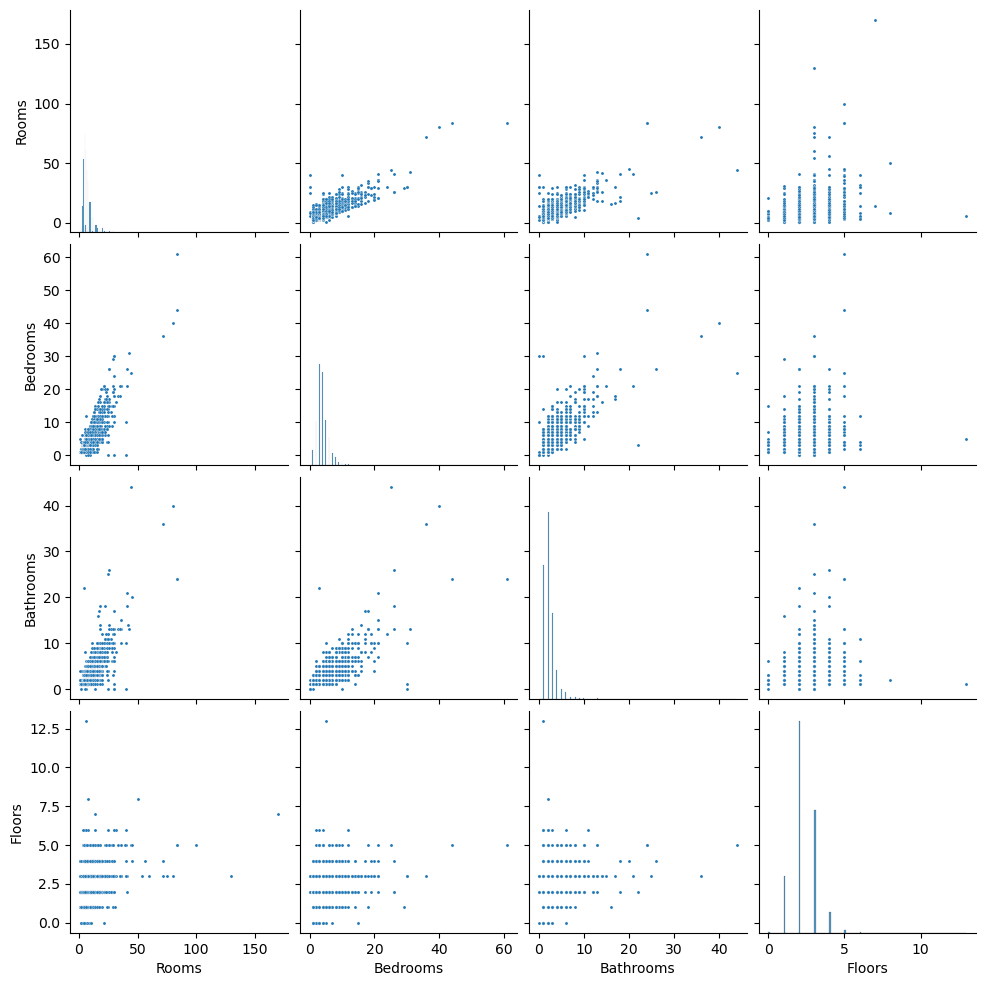

In [11]:
sns.pairplot(data[['Rooms', 'Bedrooms', 'Bathrooms', 'Floors']], plot_kws={"s": 5})
plt.show()

`Floors` is not correlated to the other columns, so keep it. `Bedrooms` show correlation to `Rooms` and `Bathrooms`, so drop `Bedrooms`. `Bathroom` shows some correlation to `Rooms`. Wether to drop `Bathrooms` should be decided by the increase in sample counts.

In [12]:
len(data.drop(columns=['Energy_efficiency_class', 'Bedrooms']).dropna())

3174

In [13]:
len(data.drop(columns=['Energy_efficiency_class', 'Bedrooms', 'Bathrooms']).dropna())

3479

We should keep `Bathrooms`, because dropping it only yields 300 more samples while neglecting possibly important information. Note that the number of bath rooms can be regarded as a measure for overall furnishing quality. Thus, there should be some correlation to `Furnishing_quality`.

In [14]:
data.groupby('Furnishing_quality')['Bathrooms'].mean()

Furnishing_quality
basic      2.207496
normal     2.363720
refined    1.826739
luxury     2.778761
Name: Bathrooms, dtype: float64

In addition, judging about furnishing quality of a house is highly subjective. Thus, we should drop the column to get more samples without missing data.

In [15]:
len(data.drop(columns=['Energy_efficiency_class', 'Bedrooms', 'Furnishing_quality']).dropna())

4526

The `Energy_source` is another candidate for dropping, because it has more than 1000 missing values and its influence on selling prices should be rather low.

In [16]:
for cat in data['Energy_source'].cat.categories:
    print(cat)

 Bioenergie 
 Erdgas leicht 
 Erdgas leicht, Erdgas schwer 
 Erdgas schwer 
 Erdgas schwer, Bioenergie 
 Erdgas schwer, Holz 
 Erdwärme 
 Erdwärme, Fernwärme 
 Erdwärme, Gas 
 Erdwärme, Holzpellets 
 Erdwärme, Solar 
 Erdwärme, Solar, Holzpellets, Holz 
 Erdwärme, Solar, Umweltwärme 
 Erdwärme, Strom 
 Erdwärme, Umweltwärme 
 Fernwärme 
 Fernwärme, Bioenergie 
 Fernwärme, Flüssiggas 
 Fernwärme, Nahwärme, KWK fossil 
 Fernwärme-Dampf 
 Flüssiggas 
 Flüssiggas, Holz 
 Gas 
 Gas, Bioenergie 
 Gas, Fernwärme 
 Gas, Fernwärme-Dampf 
 Gas, Holz 
 Gas, Holz-Hackschnitzel 
 Gas, KWK fossil 
 Gas, Kohle, Holz 
 Gas, Strom 
 Gas, Strom, Holz 
 Gas, Strom, Kohle, Holz 
 Gas, Wasserenergie 
 Gas, Öl 
 Gas, Öl, Holz 
 Gas, Öl, Kohle 
 Gas, Öl, Kohle, Holz 
 Gas, Öl, Strom 
 Holz 
 Holz, Bioenergie 
 Holz-Hackschnitzel 
 Holzpellets 
 Holzpellets, Gas 
 Holzpellets, Gas, Öl 
 Holzpellets, Holz 
 Holzpellets, Holz-Hackschnitzel 
 Holzpellets, Kohle, Holz 
 Holzpellets, Strom 
 Holzpellets, Öl 
 KWK 

Values are very diverse and hard to preprocess for regression. We would have to convert the column to several boolean columns. In addition, some grouping would be necessary (`Holz` is a subcategory of `Bioenergie` and so on).

In [17]:
len(data.drop(columns=['Energy_efficiency_class', 'Bedrooms', 'Furnishing_quality', 'Energy_source']).dropna())

4854

Now we have almost 5000 complete samples. Should be a good compromise between completeness and level of detail.

In [18]:
data = data.drop(columns=['Energy_efficiency_class', 'Bedrooms', 'Furnishing_quality', 'Energy_source'])
data = data.dropna()

## Outliers and Further Preprocessing

Now that we have a cleaned data set we should remove outliers. The simplest method of detecting outliers is to look at the ranges of all feature. With `describe` we get a first overview for numerical features.

In [19]:
data.describe()

Price  Living_space            Lot        Rooms    Bathrooms  \
count  4.854000e+03   4854.000000    4854.000000  4854.000000  4854.000000   
mean   5.739566e+05    209.305740    1240.636904     7.051504     2.316028   
std    5.880211e+05    118.252688    3806.518099     3.834865     1.595327   
min    0.000000e+00      0.000000       0.000000     1.000000     0.000000   
25%    2.800000e+05    135.000000     401.000000     5.000000     1.000000   
50%    4.400000e+05    180.000000     675.000000     6.000000     2.000000   
75%    6.850000e+05    248.000000    1042.000000     8.000000     3.000000   
max    1.300000e+07   1742.240000  143432.000000    84.000000    26.000000   

            Floors   Year_built  Year_renovated      Garages  
count  4854.000000  4854.000000     4854.000000  4854.000000  
mean      2.256696  1964.252369     1995.626700     2.518541  
std       0.776769    49.065052       35.389067     2.719901  
min       0.000000  1430.000000     1430.000000     1.000000  
25%       2.000000  1950.000000     1991.000000     1.000000  
50%       2.000000  1974.000000     2008.000000     2.000000  
75%       3.000000  1997.750000     2016.000000     3.000000  
max       8.000000  2021.000000     2206.000000    65.000000

### `Price` Column

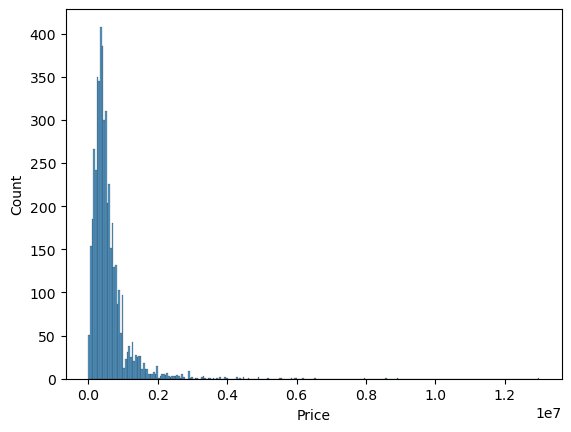

In [20]:
sns.histplot(data['Price'])
plt.show()

There are only very few high prices and price distribution concentrates on low prices. If the target variable has wide range, but most samples concentrate on a small portion of the range, then 'learning' the target is much more difficult than for more uniformly distributed data.

A common trick is to use nonlinear scaling. Especially for market prices it is known from experience that they follow a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), that is, after applying the logarithm we see a normal distribution. Before applying the logarithm we should drop samples with zeros in the `Price` column to avoid undefined results. A price of zero indicates that the seller did not provide a price in the advertisement. Thus, dropping such sample even is a good idea if we wouldn't want to apply the logarithm.

In [21]:
data = data.loc[data['Price'] > 0, :]
sns.histplot(np.log(data['Price'].to_numpy()))
plt.show()

There seem to be same very small values.

In [22]:
data.loc[data['Price'] <= np.exp(7), :]

Price    Type  Living_space     Lot  Rooms  Bathrooms  Floors  \
6987    1.0  Duplex         459.0  2742.0   23.0        8.0     3.0   

      Year_built  Year_renovated    Condition        Heating  \
6987      1957.0          1957.0  refurbished  stove heating   

                    State              City   Place  Garages Garage_type  
6987  Nordrhein-Westfalen  Märkischer Kreis  Altena      1.0      Garage

Those samples should be dropped because house prices below $\mathrm{e}^7\approx 1000$ EUR are very uncommon.

In [23]:
data['Price'] = np.log(data['Price'].to_numpy())
data = data.loc[data['Price'] > 7, :]

### `Living_space` Column

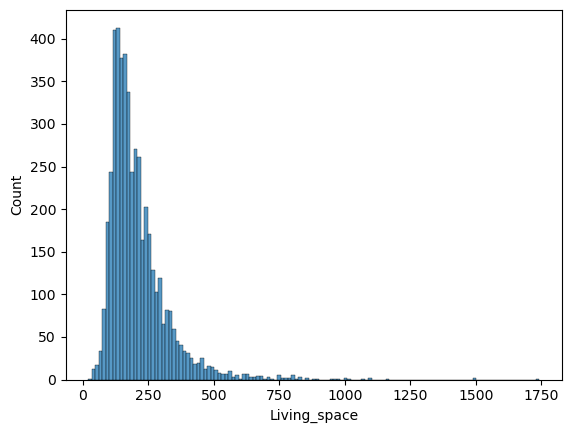

In [24]:
sns.histplot(data['Living_space'])
plt.show()

Same here as for `Price`.

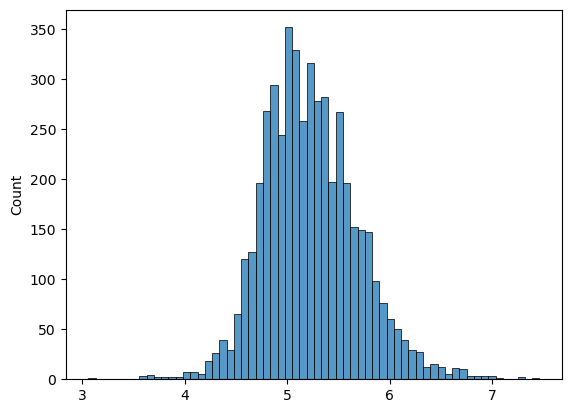

In [25]:
data = data.loc[data['Living_space'] > 0, :]
sns.histplot(np.log(data['Living_space'].to_numpy()))
plt.show()

In [26]:
data['Living_space'] = np.log(data['Living_space'].to_numpy())

### `Lot` Column

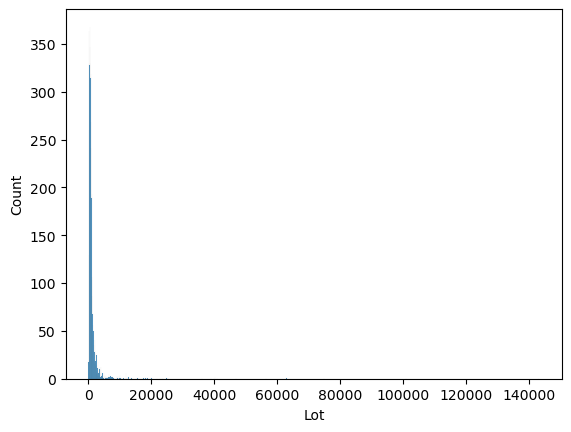

In [27]:
sns.histplot(data['Lot'])
plt.show()

Same here as for `Price` again.

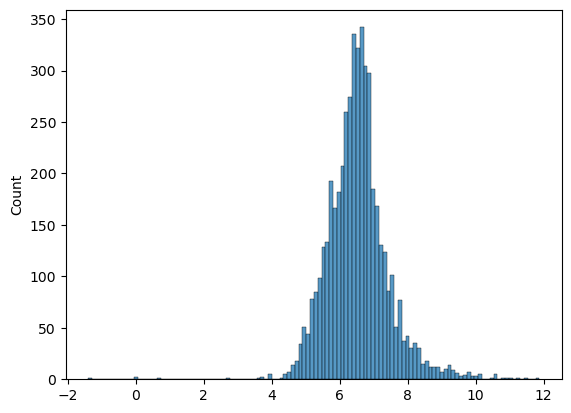

In [28]:
data = data.loc[data['Lot'] > 0, :]
sns.histplot(np.log(data['Lot'].to_numpy()))
plt.show()

In [29]:
data.loc[data['Lot'] <= np.exp(2), :]

Price                  Type  Living_space   Lot  Rooms  Bathrooms  \
722   11.492723     Mid-terrace house      4.491441  0.25    4.0        1.0   
1876  12.860362  Residential property      5.342334  1.00    5.0        1.0   
6435  11.707834                Duplex      5.056246  1.96    5.0        2.0   
7887  12.594731                Duplex      5.857933  1.00    8.0        5.0   

      Floors  Year_built  Year_renovated         Condition  \
722      3.0      1900.0          1900.0        modernized   
1876     1.0      2019.0          2019.0  first occupation   
6435     3.0      1905.0          1981.0       refurbished   
7887     3.0      1965.0          2019.0        modernized   

                  Heating                State                City     Place  \
722   wood-pellet heating    Baden-Württemberg   Main-Tauber-Kreis     Ahorn   
1876        stove heating               Bayern  Regensburg (Kreis)     Hemau   
6435        stove heating  Nordrhein-Westfalen      Höxter (Kreis)    Höxter   
7887        stove heating      Rheinland-Pfalz     Neuwied (Kreis)  Dierdorf   

      Garages          Garage_type  
722       1.0               Garage  
1876      1.0  Outside parking lot  
6435      3.0  Outside parking lot  
7887      1.0  Outside parking lot

Lot size below $\mathrm{e}^2<8$ m² is very unlikely.

In [30]:
data['Lot'] = np.log(data['Lot'].to_numpy())
data = data.loc[data['Lot'] > 2, :]

### `Rooms` Column

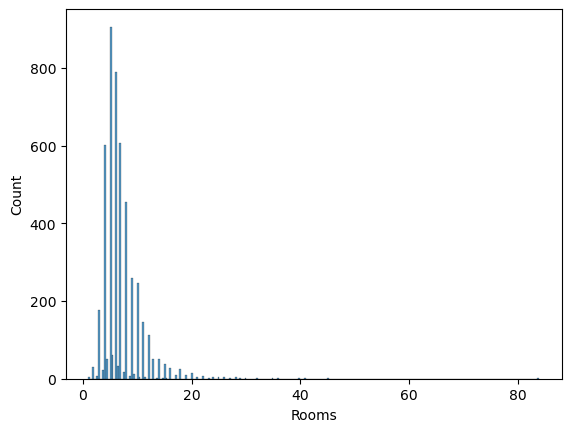

In [31]:
sns.histplot(data['Rooms'])
plt.show()

In [32]:
data.loc[data['Rooms'] >= 30, :]

Price                  Type  Living_space       Lot  Rooms  \
1863  14.430696  Residential property      6.371612  7.578145   41.0   
4322  14.346139       Single dwelling      6.745236  7.783224   30.0   
4346  15.150512                Duplex      6.690842  6.311735   36.0   
4557  12.896717                Duplex      6.653534  7.970395   36.0   
4614  13.906265                Duplex      7.306531  8.234034   84.0   
4615  13.906265                Duplex      7.306531  8.234034   84.0   
6895  13.639966                Duplex      6.516193  7.090077   32.0   
7397  13.963931                Duplex      7.057898  6.952729   45.0   
7904  13.805460                Duplex      6.682109  8.505121   35.0   
8705  14.506155              Bungalow      7.003065  8.575462   40.0   

      Bathrooms  Floors  Year_built  Year_renovated  \
1863       21.0     3.0      1907.0          2019.0   
4322        6.0     3.0      2009.0          2009.0   
4346       13.0     5.0      1961.0          2016.0   
4557       15.0     3.0      1970.0          2000.0   
4614       24.0     5.0      1991.0          2018.0   
4615       24.0     5.0      1989.0          2018.0   
6895        8.0     3.0      2003.0          2003.0   
7397       20.0     4.0      1950.0          1950.0   
7904       13.0     3.0      2004.0          2019.0   
8705        0.0     3.0      2012.0          2012.0   

                                 Condition           Heating  \
1863                            maintained     stove heating   
4322                           dilapidated     stove heating   
4346                            modernized     stove heating   
4557                            maintained     stove heating   
4614                            modernized     stove heating   
4615                            modernized     stove heating   
6895                           dilapidated  electric heating   
7397                            maintained         heat pump   
7904  first occupation after refurbishment     stove heating   
8705                           fixer-upper         heat pump   

                       State                      City       Place  Garages  \
1863                  Bayern         Eichstätt (Kreis)  Dollnstein     16.0   
4322                  Hessen  Limburg-Weilburg (Kreis)     Hadamar      4.0   
4346                  Hessen         Frankfurt am Main   Rödelheim      3.0   
4557  Mecklenburg-Vorpommern            Demmin (Kreis)     Rosenow      1.0   
4614  Mecklenburg-Vorpommern            Demmin (Kreis)     Kruckow     16.0   
4615  Mecklenburg-Vorpommern            Demmin (Kreis)     Kruckow     16.0   
6895     Nordrhein-Westfalen             Gelsenkirchen      Hassel      8.0   
7397     Nordrhein-Westfalen             Gelsenkirchen       Horst     12.0   
7904         Rheinland-Pfalz    Trier-Saarburg (Kreis)    Saarburg     15.0   
8705         Rheinland-Pfalz       Vulkaneifel (Kreis)  Gerolstein     40.0   

              Garage_type  
1863  Outside parking lot  
4322  Outside parking lot  
4346               Garage  
4557  Outside parking lot  
4614  Outside parking lot  
4615  Outside parking lot  
6895          Parking lot  
7397  Outside parking lot  
7904  Outside parking lot  
8705          Parking lot

There are only very few sample with high number of rooms. There is no chance to get good predictions from those few samples.

In [33]:
data = data.loc[data['Rooms'] < 30, :]

### `Bathrooms` Column

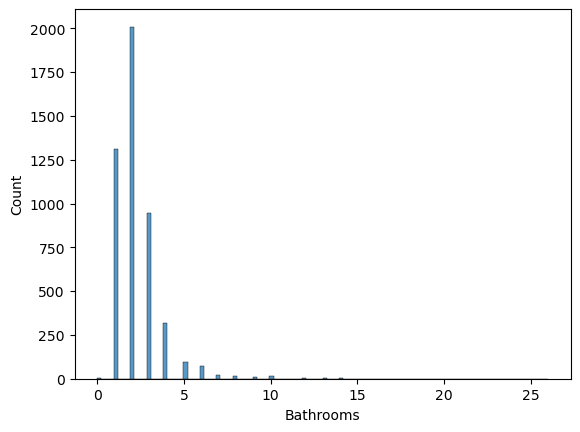

In [34]:
sns.histplot(data['Bathrooms'])
plt.show()

In [35]:
data.loc[data['Bathrooms'] >= 15, :]

Price               Type  Living_space       Lot  Rooms  Bathrooms  \
3270   15.264780             Duplex      7.462927  7.693605   26.0       26.0   
6006   13.457406           Bungalow      6.514713  8.750366   25.0       25.0   
7224   14.038654             Duplex      6.476972  6.063785   18.0       18.0   
10088  12.037654  Multiple dwelling      4.499810  5.777652    4.0       22.0   

       Floors  Year_built  Year_renovated   Condition             Heating  \
3270      4.0      1994.0          1994.0  modernized           heat pump   
6006      3.0      1874.0          2016.0   renovated  cogeneration units   
7224      4.0      1962.0          1962.0  modernized       stove heating   
10088     2.0      1961.0          2000.0  modernized           heat pump   

                     State                         City                Place  \
3270           Brandenburg       Teltow-Fläming (Kreis)  Blankenfelde-Mahlow   
6006         Niedersachsen    Lüchow-Dannenberg (Kreis)               Küsten   
7224   Nordrhein-Westfalen              Herford (Kreis)              Herford   
10088   Schleswig-Holstein  Schleswig-Flensburg (Kreis)                 Tarp   

       Garages          Garage_type  
3270      26.0           Duplex lot  
6006      30.0  Outside parking lot  
7224       5.0               Garage  
10088      1.0  Outside parking lot

In [36]:
data = data.loc[data['Bathrooms'] < 15, :]

### `Floors` Column

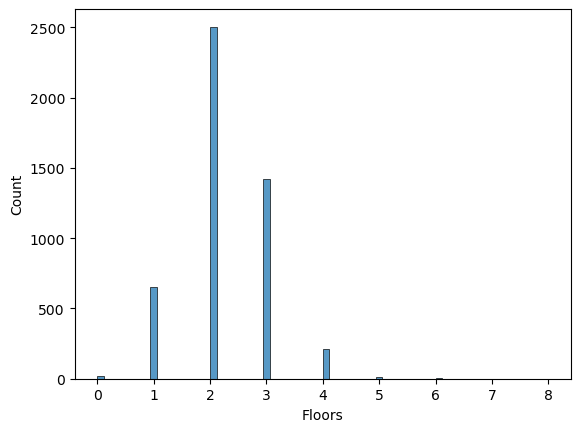

In [37]:
sns.histplot(data['Floors'])
plt.show()

Nothing to do here.

### `Year_built` Column

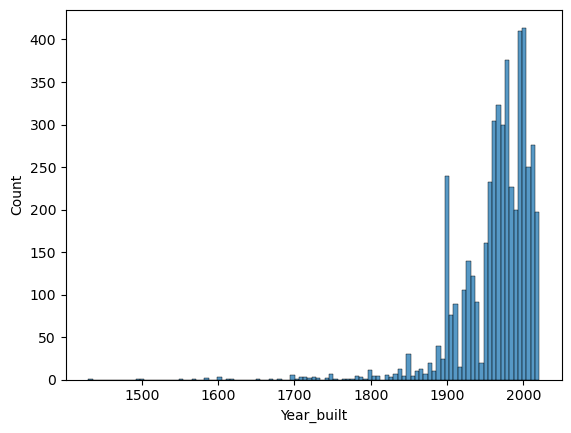

In [38]:
sns.histplot(data['Year_built'])
plt.show()

In [39]:
data.loc[data['Year_built'] <= 1500, :]

Price          Type  Living_space        Lot  Rooms  Bathrooms  \
1311  14.580978  Corner house      6.182085  11.522876   13.0        7.0   
1458  14.077875        Duplex      6.522093   6.361302   19.0        9.0   
8174  12.203570      Bungalow      5.703782   5.634790   10.0        2.0   

      Floors  Year_built  Year_renovated    Condition             Heating  \
1311     3.0      1430.0          1430.0  fixer-upper       stove heating   
1458     3.0      1500.0          2014.0   modernized  underfloor heating   
8174     4.0      1492.0          1492.0  refurbished       stove heating   

                State                          City              Place  \
1311           Bayern  Berchtesgadener Land (Kreis)  Marktschellenberg   
1458           Bayern                       Ansbach              Stadt   
8174  Rheinland-Pfalz         Bad Kreuznach (Kreis)      Bad Kreuznach   

      Garages Garage_type  
1311      2.0     Carport  
1458      9.0     Carport  
8174      2.0      Garage

In [40]:
data = data.loc[data['Year_built'] > 1500, :]

Values above 2020 obviously are wrong (data set is from 2020).

In [41]:
data.loc[data['Year_built'] > 2020, :]

Price               Type  Living_space       Lot  Rooms  Bathrooms  \
2437  13.623139    Single dwelling      4.897840  5.609472    4.5        1.0   
2515  13.704579    Single dwelling      4.875197  5.796058    4.0        1.0   
2516  13.704579    Single dwelling      4.875197  5.963579    4.0        1.0   
2519  13.928839  Mid-terrace house      4.962845  6.061457    4.5        2.0   
2520  13.981025  Mid-terrace house      4.962845  6.165418    4.5        2.0   
2521  13.652992    Single dwelling      4.897840  5.700444    4.5        1.0   

      Floors  Year_built  Year_renovated    Condition        Heating   State  \
2437     3.0      2021.0          2021.0  dilapidated  stove heating  Bayern   
2515     3.0      2021.0          2021.0  dilapidated  stove heating  Bayern   
2516     3.0      2021.0          2021.0  dilapidated  stove heating  Bayern   
2519     3.0      2021.0          2021.0  dilapidated  stove heating  Bayern   
2520     3.0      2021.0          2021.0  dilapidated  stove heating  Bayern   
2521     3.0      2021.0          2021.0  dilapidated  stove heating  Bayern   

                   City       Place  Garages  Garage_type  
2437  Rosenheim (Kreis)  Kolbermoor      2.0  Parking lot  
2515  Ebersberg (Kreis)   Zorneding      2.0  Parking lot  
2516  Ebersberg (Kreis)   Zorneding      2.0  Parking lot  
2519  Rosenheim (Kreis)  Kolbermoor      2.0  Parking lot  
2520  Rosenheim (Kreis)  Kolbermoor      2.0  Parking lot  
2521  Rosenheim (Kreis)  Kolbermoor      2.0  Parking lot

In [42]:
data = data.loc[data['Year_built'] <= 2020, :]

To get a better distribution of the samples over the range, we again apply a logarithmic transform.

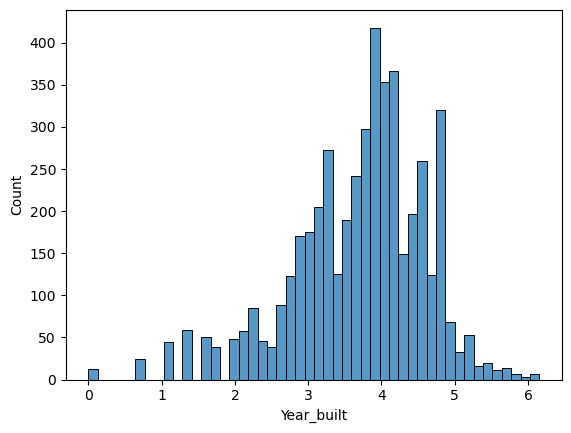

In [43]:
data.loc[:, 'Year_built'] = np.log(2021 - data['Year_built'].to_numpy())
sns.histplot(data['Year_built'])
plt.show()

### `Year_renovated` Column

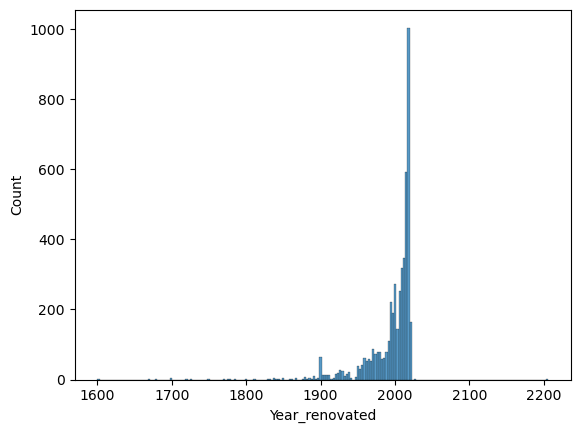

In [44]:
sns.histplot(data['Year_renovated'])
plt.show()

There seem to be renovations before 1900, which seems somewhat strange. But remember that we filled missing values with values from `Year_built`. Values above 2020 obviously are wrong.

In [45]:
data.loc[data['Year_renovated'] > 2020, :]

Price               Type  Living_space       Lot  Rooms  Bathrooms  \
7803  12.992255             Duplex      6.969791  6.818924   26.0       13.0   
9324  12.971540  Mid-terrace house      5.075174  6.486161    6.0        2.0   

      Floors  Year_built  Year_renovated       Condition    Heating  \
7803     2.0    4.025352          2026.0  by arrangement  heat pump   
9324     3.0    4.727388          2206.0      modernized  heat pump   

                State                    City         Place  Garages  \
7803  Rheinland-Pfalz  Trier-Saarburg (Kreis)     Reinsfeld     15.0   
9324          Sachsen                 Zwickau  Nordvorstadt      2.0   

              Garage_type  
7803          Parking lot  
9324  Outside parking lot

In [46]:
data = data.loc[data['Year_renovated'] <= 2020, :]

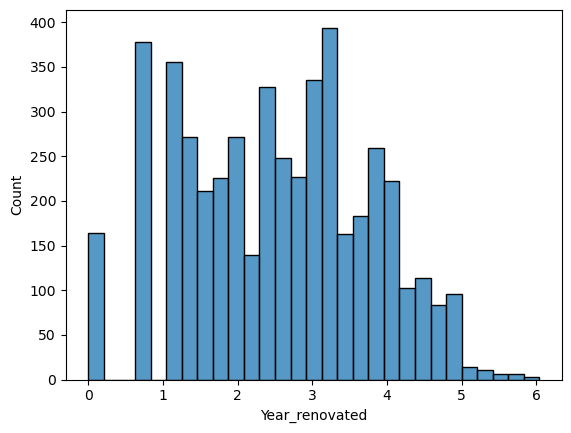

In [47]:
data.loc[:, 'Year_renovated'] = np.log(2021 - data['Year_renovated'].to_numpy())
sns.histplot(data['Year_renovated'])
plt.show()

### `Garages` Column

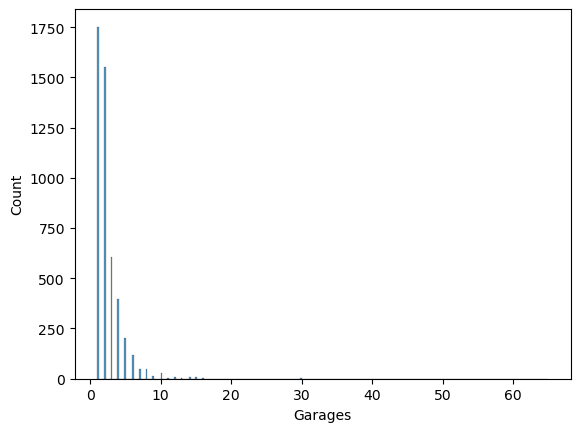

In [48]:
sns.histplot(data['Garages'])
plt.show()

In [49]:
data.loc[data['Garages'] >= 20, :]

Price          Type  Living_space        Lot  Rooms  Bathrooms  \
461   14.343193      Bungalow      5.347108   8.932609    8.0        2.0   
2579  14.220976        Duplex      6.278521   8.027150   15.0        4.0   
3761  15.009130      Bungalow      6.476972   8.116716   10.0        2.0   
3932  13.384728        Duplex      5.375278   8.809714   15.0        7.0   
4175  14.066269        Duplex      5.777652   6.884487   11.0        5.0   
4243  11.407565        Duplex      3.058707   7.342132    1.0        1.0   
7166  13.102161      Bungalow      7.003065   9.239899   12.0        3.0   
7870  12.959844  Corner house      5.828946  10.596635   14.0        2.0   
9535  13.910821        Duplex      6.415097   8.097122   22.0        8.0   

      Floors  Year_built  Year_renovated    Condition             Heating  \
461      3.0    3.332205        3.332205   modernized       stove heating   
2579     2.0    3.761200        2.397895   modernized  underfloor heating   
3761     3.0    5.293305        1.609438    renovated           heat pump   
3932     4.0    4.510860        4.510860   maintained       stove heating   
4175     2.0    3.496508        0.000000   modernized       stove heating   
4243     4.0    3.912023        3.912023   modernized           heat pump   
7166     1.0    3.970292        2.639057   modernized         gas heating   
7870     3.0    4.795791        1.609438  dilapidated       stove heating   
9535     3.0    3.091042        3.091042   modernized       stove heating   

                    State                               City  \
461     Baden-Württemberg                Ludwigsburg (Kreis)   
2579               Bayern                 Rottal-Inn (Kreis)   
3761               Hessen                  Frankfurt am Main   
3932               Hessen          Darmstadt-Dieburg (Kreis)   
4175               Hessen           Limburg-Weilburg (Kreis)   
4243               Hessen                  Main-Taunus-Kreis   
7166  Nordrhein-Westfalen            Minden-Lübbecke (Kreis)   
7870      Rheinland-Pfalz  Altenkirchen (Westerwald) (Kreis)   
9535       Sachsen-Anhalt                      Salzlandkreis   

                     Place  Garages          Garage_type  
461   Vaihingen an der Enz     30.0  Outside parking lot  
2579           Eggenfelden     22.0          Parking lot  
3761           Niederursel     20.0  Outside parking lot  
3932               Otzberg     60.0  Outside parking lot  
4175           Bad Camberg     21.0  Outside parking lot  
4243   Hattersheim am Main     30.0          Parking lot  
7166             Espelkamp     65.0          Parking lot  
7870              Birnbach     50.0  Outside parking lot  
9535      Bernburg (Saale)     58.0  Outside parking lot

In [50]:
data = data.loc[data['Garages'] < 20, :]

### `Type` Column

In [51]:
data['Type'].value_counts()

Mid-terrace house       2198
Duplex                   868
Single dwelling          565
Farmhouse                265
Villa                    213
Multiple dwelling        209
Special property         168
Residential property     124
Bungalow                 113
Corner house              78
Castle                     2
Name: Type, dtype: int64

In [52]:
data = data.loc[data['Type'] != 'Castle', :]
data['Type'] = data['Type'].cat.remove_categories('Castle')

### `Condition` Column

In [53]:
data['Condition'].value_counts()

modernized                              2146
dilapidated                              663
refurbished                              565
renovated                                509
maintained                               361
fixer-upper                              268
first occupation after refurbishment     210
first occupation                          50
by arrangement                            26
as new                                     3
Name: Condition, dtype: int64

We should remove `'as new'` and `'by arrangement'` because only few samples use these categories and both are somewhat dubious.

In [54]:
data = data.loc[~data['Condition'].isin(['as new', 'by arrangement']), :]
data['Condition'] = data['Condition'].cat.remove_categories(['as new', 'by arrangement'])

### `Heating` Column

In [55]:
data['Heating'].value_counts()

stove heating           2900
heat pump                563
oil heating              420
central heating          248
underfloor heating       162
night storage heater     138
district heating         117
wood-pellet heating       62
floor heating             55
electric heating          52
gas heating               32
cogeneration units        13
solar heating             10
Name: Heating, dtype: int64

Something is wrong here! More than every second house sold in 2020 has stove heating? And what about `'floor heating'`? Is it gas powered or oil powered or what else? What's the difference between `'floor heating'` and `'underfloor heating'`. It's better to drop this column.

In [56]:
data = data.drop(columns=['Heating'])

### `Garage_type` Column

In [57]:
data['Garage_type'].value_counts()

Garage                     2647
Outside parking lot         897
Parking lot                 739
Carport                     409
Underground parking lot      53
Duplex lot                   26
Car park lot                  1
Name: Garage_type, dtype: int64

There are many similar categories. We should join some.

In [58]:
data.loc[data['Garage_type'] == 'Car park lot', 'Garage_type'] = 'Outside parking lot'
data.loc[data['Garage_type'] == 'Duplex lot', 'Garage_type'] = 'Outside parking lot'
data.loc[data['Garage_type'] == 'Parking lot', 'Garage_type'] = 'Outside parking lot'
data['Garage_type'] = data['Garage_type'].cat.remove_categories(['Car park lot', 'Duplex lot', 'Parking lot'])

data['Garage_type'].value_counts()

Garage                     2647
Outside parking lot        1663
Carport                     409
Underground parking lot      53
Name: Garage_type, dtype: int64

## Save Cleaned Data

We save cleaned data for future use.

In [59]:
data.to_csv(data_path.replace('.csv', '_preprocessed.csv'))

## Linear Regression

Now data is almost ready for training a model. It remains to convert categorical data to numerical data. `Condition` is ordered and numeric representation is accessible with [`Series.cat.codes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.codes.html). Columns `Type` and `Garage_type` should be one-hot encoded.

In [60]:
data['Condition_codes'] = data['Condition'].cat.codes
data = pd.get_dummies(data, columns=['Type', 'Garage_type'], drop_first=True)

In [61]:
data.head()

Price  Living_space       Lot  Rooms  Bathrooms  Floors  Year_built  \
0   13.118355      4.663439  5.433722    5.5        1.0     2.0    2.772589   
2   13.526494      5.093075  4.406719    5.0        2.0     4.0    2.079442   
3   12.464583      4.941642  6.701960    4.0        2.0     2.0    4.795791   
8   12.804909      5.424950  6.880384   10.0        4.0     2.0    5.356586   
10  14.375126      5.347108  7.286192    6.0        2.0     3.0    4.406719   

    Year_renovated    Condition              State               City  \
0         2.772589   modernized  Baden-Württemberg      Bodenseekreis   
2         2.079442  dilapidated  Baden-Württemberg  Esslingen (Kreis)   
3         3.044522  fixer-upper  Baden-Württemberg   Waldshut (Kreis)   
8         1.791759   modernized  Baden-Württemberg           Enzkreis   
10        1.945910   modernized  Baden-Württemberg          Stuttgart   

                      Place  Garages  Condition_codes  Type_Corner house  \
0               Bermatingen      2.0                4                  0   
2                Ostfildern      1.0                7                  0   
3   Bonndorf im Schwarzwald      1.0                6                  0   
8                 Neuenbürg      8.0                4                  0   
10                Schönberg      2.0                4                  0   

    Type_Duplex  Type_Farmhouse  Type_Mid-terrace house  \
0             0               0                       0   
2             0               1                       0   
3             0               1                       0   
8             1               0                       0   
10            0               0                       1   

    Type_Multiple dwelling  Type_Residential property  Type_Single dwelling  \
0                        1                          0                     0   
2                        0                          0                     0   
3                        0                          0                     0   
8                        0                          0                     0   
10                       0                          0                     0   

    Type_Special property  Type_Villa  Garage_type_Garage  \
0                       0           0                   0   
2                       0           0                   1   
3                       0           0                   1   
8                       0           0                   0   
10                      0           0                   1   

    Garage_type_Outside parking lot  Garage_type_Underground parking lot  
0                                 1                                    0  
2                                 0                                    0  
3                                 0                                    0  
8                                 1                                    0  
10                                0                                    0

We drop columns not used for regression and convert the data frame to NumPy arrays suitable for Scikit-Learn.

In [62]:
y = data['Price'].to_numpy()
X = data.drop(columns=['Price', 'Condition', 'State', 'City', 'Place']).to_numpy()

print(X.shape, y.shape)

(4772, 21) (4772,)


We have relatively few data. Thus, test set should be small to have more training samples.

In [63]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(y_train.size, y_test.size)

3817 955


We use polynomial regression with regularization.

In [64]:
steps = [('poly', preprocessing.PolynomialFeatures()),
         ('ridge', linear_model.Ridge())]

pipe = pipeline.Pipeline(steps)

param_grid = {'poly__degree': [1, 2, 3],
              'ridge__alpha': [0] + [2 ** k for k in range(5, 15)]}

gs = model_selection.GridSearchCV(pipe, param_grid=param_grid,
                                  scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

gs.fit(X_train, y_train)
best_params = gs.best_params_

## Evaluating the Model

Now we use the test set to evaluate prediction quality of the model.

In [65]:
print(best_params)

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)

y_test_pred = pipe.predict(X_test)

{'poly__degree': 2, 'ridge__alpha': 64}


Root mean squared error between predicted and exact targets on its own does not tell much about fitting quality. We have to compare the value to standard deviation of the targets. Standard deviation is the root mean squared error of the exact targets and their mean. In other words, standard deviation tells us the prediction error if we would use constant predictions for all inputs. Obviously the constant should be the mean of the training (!) targets, but the mean of the training targets should be very close the mean of the test targets if test sample have been selected randomly.

In [66]:
rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
sigma = np.std(y_test)
print('RMSE:', rmse)
print('standard deviation:', sigma)
print('ratio:', rmse / sigma)

RMSE: 0.549529269010328
standard deviation: 0.7553775997302192
ratio: 0.7274894955934497


We see that the model's prediction is better than constant prediction, but not so much.

We should have a closer look at the predictions. Since there is no natural ordering in the set of samples plotting `y_test` and `y_test_pred` with `plot` does not help much.

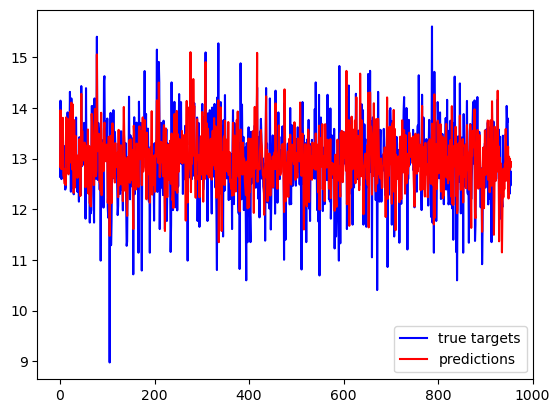

In [67]:
fig, ax = plt.subplots()
ax.plot(y_test, '-b', label='true targets')
ax.plot(y_test_pred, '-r', label='predictions')
ax.legend()
plt.show()

A better idea is to plot `y_test` versus `y_test_pred`. If true and predicted labels are close, then points should concentrate along the diagonal. Else they are far away from the diagonal.

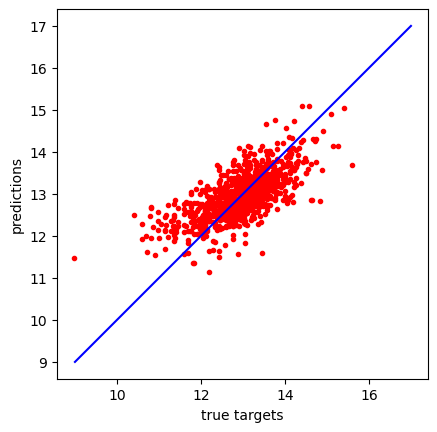

In [68]:
fig, ax = plt.subplots()
ax.plot(y_test, y_test_pred, 'or', markersize=3)
ax.plot([9, 17], [9, 17], '-b')
ax.set_xlabel('true targets')
ax.set_ylabel('predictions')
ax.set_aspect('equal')
plt.show()

The red cloud shows some rotation compared to the blue line. Small target values get too high predictions and high target values get too low predictions. In other words, predictions tend to be too close to the target's mean. Such behavior is typically observed if there are many similar samples with different targets in the training data. Then there is no clear functional dependence of the targets on the inputs and models tend to predict the mean targets.

To further investigate this issue we should look at the predictions on the training set. If we are right, then predictions on the training set should show similar behavior (predictions close to mean).

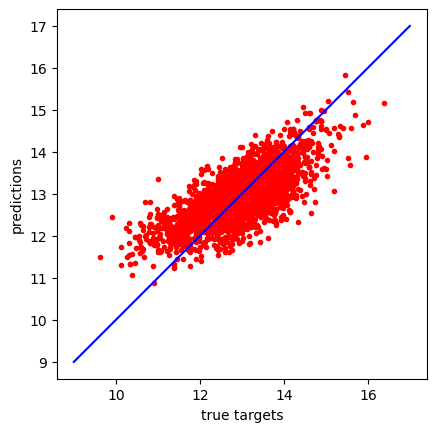

In [69]:
y_train_pred = pipe.predict(X_train)

fig, ax = plt.subplots()
ax.plot(y_train, y_train_pred, 'or', markersize=3)
ax.plot([9, 17], [9, 17], '-b')
ax.set_xlabel('true targets')
ax.set_ylabel('predictions')
ax.set_aspect('equal')
plt.show()

Again we see slight rotation. To summarize: our input data has too few details to explain the targets. There are simlar inputs with different targets leading to underestimation of high values and over estimation of low values. The only way out is gathering more data, either by dropping less columns or by getting relevant data from additional sources. We will come back to this issue soon.

## Predictions

When using our model for predicting house prices we have to keep in mind that we transformed some of the input data. All those transforms have to be applied to new inputs, too.

In [70]:
living_space = 80
lot = 3600
rooms = 5
bathrooms = 0
floors = 2
year_built = 1948
year_renovated = 1948
garages = 2
condition_codes = 7    # 0 = 'first occupation', 7 = 'dilapidated'
type_corner_house = 0
type_duplex = 0
type_farmhouse = 1
type_midterrace_house = 0
type_multiple_dwelling = 0
type_residential_property = 0
type_single_dwelling = 0
type_special_property = 0
type_villa = 0
garage_type_garage = 0
garage_type_outside_parking_lot = 1
garage_type_underground_parking_lot = 0

X = np.asarray([np.log(living_space), np.log(lot), rooms, bathrooms, floors,
                np.log(2021 - year_built), np.log(2021 - year_renovated),
                garages, condition_codes, type_corner_house, type_duplex, type_farmhouse,
                type_midterrace_house, type_multiple_dwelling, type_residential_property,
                type_single_dwelling, type_special_property, type_villa,
                garage_type_garage, garage_type_outside_parking_lot,
                garage_type_underground_parking_lot]).reshape(1, -1)

y = np.exp(pipe.predict(X))

print('predicted price: {:.0f} EUR'.format(y[0]))

predicted price: 115455 EUR
